In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import gc

from source.events import make_scores, quarter_score, lead_changes, event_count, make_competitive
from source.events_plot import plot_game, get_game

pd.set_option('max_columns', 300)

In [2]:
df_2020 = pd.read_csv('data/raw_men/MEvents2020.csv')

df_2020 = make_scores(df_2020)
df_2020 = quarter_score(df_2020)
df_2020 = lead_changes(df_2020)
df_2020 = event_count(df_2020)

df_2020.head()

,Season,DayNum,tourney,WTeamID,LTeamID,WFinalScore,LFinalScore,Final_difference,n_OT,Halftime_difference,3mins_difference,game_lc,half2_lc,crunchtime_lc,Wpoints_made_half2,Lpoints_made_half2,Wpoints_made_crunchtime,Lpoints_made_crunchtime,Wmade1_game,Lmade1_game,Wmade2_game,Lmade2_game,Wmade3_game,Lmade3_game,Wreb_game,Lreb_game,Wturnover_game,Lturnover_game,Wassist_game,Lassist_game,Wsteal_game,Lsteal_game,Wblock_game,Lblock_game,Wmade1_half2,Lmade1_half2,Wmade2_half2,Lmade2_half2,Wmade3_half2,Lmade3_half2,Wreb_half2,Lreb_half2,Wturnover_half2,Lturnover_half2,Wassist_half2,Lassist_half2,Wsteal_half2,Lsteal_half2,Wblock_half2,Lblock_half2,Wmade1_crunchtime,Lmade1_crunchtime,Wmade2_crunchtime,Lmade2_crunchtime,Wmade3_crunchtime,Lmade3_crunchtime,Wreb_crunchtime,Lreb_crunchtime,Wturnover_crunchtime,Lturnover_crunchtime,Wassist_crunchtime,Lassist_crunchtime,Wsteal_crunchtime,Lsteal_crunchtime,Wblock_crunchtime,Lblock_crunchtime,WAst_perc_game,LAst_perc_game,WFGM_perc_game,LFGM_perc_game,WFGM3_perc_game,LFGM3_perc_game,WFTM_perc_game,LFTM_perc_game,WAst_perc_half2,LAst_perc_half2,WFGM_perc_half2,LFGM_perc_half2,WFGM3_perc_half2,LFGM3_perc_half2,WFTM_perc_half2,LFTM_perc_half2,WAst_perc_crunchtime,LAst_perc_crunchtime,WFGM_perc_crunchtime,LFGM_perc_crunchtime,WFGM3_perc_crunchtime,LFGM3_perc_crunchtime,WFTM_perc_crunchtime,LFTM_perc_crunchtime
0,2020,1,0,1114,1283,67,66,1,0.0,-6.0,-1.0,16,3,3,34.0,27.0,4.0,2.0,10,12,24,15,3,8,36,31,13,10,17,10,7,7,3,3,5,5,13,5,1,4,18,11,6,7,8,3,4,4,1,0,0,2,2,0,0,0,4,1,1,1,1,0,0,1,0,0,0.629630,0.434783,0.519231,0.425926,0.214286,0.285714,0.666667,0.666667,0.571429,0.333333,0.538462,0.391304,0.125000,0.363636,0.833333,0.714286,0.50,0.0,0.500000,0.000000,0.0,0.0,0.000,1.0
1,2020,1,0,1116,1349,91,43,48,0.0,20.0,48.0,4,0,0,52.0,24.0,6.0,6.0,7,9,27,14,10,2,48,31,21,27,19,7,14,9,5,2,4,8,15,8,6,0,25,17,12,15,11,5,11,7,3,1,0,2,3,2,0,0,3,3,1,1,0,1,1,1,0,0,0.513514,0.437500,0.552239,0.285714,0.400000,0.080000,0.636364,0.600000,0.523810,0.625000,0.617647,0.258065,0.461538,0.000000,0.666667,0.727273,0.00,0.5,0.600000,0.666667,0.0,0.0,0.000,0.5
2,2020,1,0,1120,1204,83,74,9,0.0,4.0,12.0,24,0,0,42.0,37.0,9.0,10.0,18,15,22,22,7,5,44,28,21,18,13,8,6,10,2,2,15,7,12,9,1,4,24,15,8,10,4,4,1,5,1,0,5,4,1,3,0,0,5,3,0,1,0,0,0,0,0,0,0.448276,0.296296,0.500000,0.473684,0.318182,0.277778,0.720000,0.714286,0.307692,0.307692,0.464286,0.464286,0.111111,0.444444,0.789474,0.636364,0.00,0.0,0.333333,0.600000,0.0,0.0,0.625,0.8
3,2020,1,0,1124,1146,105,61,44,0.0,21.0,34.0,1,0,0,52.0,29.0,10.0,0.0,7,13,22,18,18,4,53,35,14,15,25,11,6,5,2,6,1,3,12,10,9,2,28,17,8,8,14,6,4,3,1,2,0,0,2,0,2,0,7,4,0,2,3,0,1,0,1,0,0.625000,0.500000,0.563380,0.360656,0.545455,0.173913,0.500000,0.541667,0.666667,0.500000,0.552632,0.363636,0.500000,0.153846,0.200000,0.500000,0.75,0.0,0.500000,0.000000,0.4,0.0,0.000,0.0
4,2020,1,0,1135,1136,73,71,2,0.0,0.0,0.0,30,20,8,39.0,38.0,6.0,4.0,22,13,18,17,5,8,44,40,15,12,9,14,7,9,2,0,13,5,10,9,2,5,20,18,5,5,4,7,3,2,0,0,3,2,1,1,0,0,4,4,0,1,0,0,1,0,0,0,0.391304,0.560000,0.433962,0.403226,0.294118,0.285714,0.709677,0.619048,0.333333,0.500000,0.480000,0.451613,0.285714,0.333333,0.764706,0.625000,0.00,0.0,0.333333,0.250000,0.0,0.0,0.750,0.5


In [3]:
df_2020 = pd.read_csv('data/raw_women/WEvents2020.csv')

df_2020 = make_scores(df_2020)
df_2020 = quarter_score(df_2020, men=False)
df_2020 = lead_changes(df_2020)
df_2020 = event_count(df_2020)

df_2020.head()

,Season,DayNum,tourney,WTeamID,LTeamID,WFinalScore,LFinalScore,Final_difference,n_OT,Halftime_difference,3mins_difference,game_lc,half2_lc,crunchtime_lc,Wpoints_made_half2,Lpoints_made_half2,Wpoints_made_crunchtime,Lpoints_made_crunchtime,Wmade1_game,Lmade1_game,Wmade2_game,Lmade2_game,Wmade3_game,Lmade3_game,Wreb_game,Lreb_game,Wturnover_game,Lturnover_game,Wassist_game,Lassist_game,Wsteal_game,Lsteal_game,Wblock_game,Lblock_game,Wmade1_half2,Lmade1_half2,Wmade2_half2,Lmade2_half2,Wmade3_half2,Lmade3_half2,Wreb_half2,Lreb_half2,Wturnover_half2,Lturnover_half2,Wassist_half2,Lassist_half2,Wsteal_half2,Lsteal_half2,Wblock_half2,Lblock_half2,Wmade1_crunchtime,Lmade1_crunchtime,Wmade2_crunchtime,Lmade2_crunchtime,Wmade3_crunchtime,Lmade3_crunchtime,Wreb_crunchtime,Lreb_crunchtime,Wturnover_crunchtime,Lturnover_crunchtime,Wassist_crunchtime,Lassist_crunchtime,Wsteal_crunchtime,Lsteal_crunchtime,Wblock_crunchtime,Lblock_crunchtime,WAst_perc_game,LAst_perc_game,WFGM_perc_game,LFGM_perc_game,WFGM3_perc_game,LFGM3_perc_game,WFTM_perc_game,LFTM_perc_game,WAst_perc_half2,LAst_perc_half2,WFGM_perc_half2,LFGM_perc_half2,WFGM3_perc_half2,LFGM3_perc_half2,WFTM_perc_half2,LFTM_perc_half2,WAst_perc_crunchtime,LAst_perc_crunchtime,WFGM_perc_crunchtime,LFGM_perc_crunchtime,WFGM3_perc_crunchtime,LFGM3_perc_crunchtime,WFTM_perc_crunchtime,LFTM_perc_crunchtime
0,2020,1,0,3107,3162,82,78,4,1.0,6.0,4.0,10,7,1,48.0,50.0,14.0,16.0,13,5,21,32,9,3,43,60,8,16,15,15,5,3,2,2,6,3,12,18,3,2,18,31,4,7,8,7,2,2,1,1,2,3,0,4,1,0,1,5,2,1,1,1,0,2,1,0,0.500000,0.428571,0.394737,0.416667,0.243243,0.187500,0.684211,0.714286,0.533333,0.350000,0.441176,0.454545,0.200000,0.285714,0.545455,0.750000,1.000000,0.25,0.500000,0.571429,0.5,0.000000,0.500000,1.0
1,2020,1,0,3112,3315,74,42,32,0.0,18.0,31.0,4,0,0,39.0,25.0,5.0,4.0,2,11,24,8,8,5,40,44,14,27,18,8,15,8,4,4,2,9,11,5,5,2,20,23,6,11,10,6,7,4,1,3,0,0,1,2,1,0,5,5,0,0,2,2,0,0,0,2,0.562500,0.615385,0.438356,0.276596,0.347826,0.238095,0.666667,0.578947,0.625000,0.857143,0.432432,0.291667,0.555556,0.142857,1.000000,0.692308,1.000000,1.00,0.285714,0.285714,1.0,0.000000,0.000000,0.0
2,2020,1,0,3113,3102,87,56,31,0.0,11.0,27.0,7,0,0,47.0,27.0,6.0,2.0,14,9,29,19,5,3,43,39,18,22,15,9,11,5,3,2,5,4,18,10,2,1,20,21,9,14,8,3,7,3,2,1,0,0,3,1,0,0,3,2,0,2,1,0,1,0,0,0,0.441176,0.409091,0.539683,0.360656,0.384615,0.250000,0.777778,0.473684,0.400000,0.272727,0.625000,0.354839,0.333333,0.111111,0.625000,0.400000,0.333333,0.00,0.600000,0.250000,0.0,0.000000,0.000000,0.0
3,2020,1,0,3124,3306,97,29,68,0.0,48.0,64.0,1,0,0,46.0,26.0,7.0,3.0,17,9,37,7,2,2,62,33,12,24,29,3,13,4,8,1,8,8,19,6,0,2,29,14,7,8,15,2,5,4,4,1,1,0,3,0,0,1,6,2,1,1,2,0,0,0,1,0,0.743590,0.333333,0.565217,0.155172,0.500000,0.105263,0.680000,0.529412,0.789474,0.250000,0.612903,0.266667,0.000000,0.250000,0.666667,0.615385,0.666667,0.00,0.750000,0.166667,0.0,0.333333,0.333333,0.0
4,2020,1,0,3127,3373,89,62,27,0.0,18.0,30.0,3,0,0,42.0,33.0,0.0,3.0,15,13,22,17,10,5,47,41,8,20,19,11,6,3,0,2,2,10,11,10,6,1,24,22,5,10,9,5,3,2,0,1,0,1,0,1,0,0,2,5,1,3,0,1,1,0,0,0,0.593750,0.500000,0.410256,0.392857,0.476190,0.277778,0.882353,0.684211,0.529412,0.454545,0.395349,0.423077,0.500000,0.166667,0.666667,0.769231,0.000000,1.00,0.000000,0.500000,0.0,0.000000,0.000000,0.5


In [2]:
all_events_m = []

for year in np.arange(2015, 2021):
    print(year)
    df = pd.read_csv(f'data/raw_men/MEvents{year}.csv')
    df = make_scores(df)
    df = quarter_score(df)
    df = lead_changes(df)
    df = event_count(df)
    all_events_m.append(df)
    gc.collect()

all_events_m = pd.concat(all_events_m, ignore_index=True)

all_events_m.head()

2015
2016
2017
2018
2019
2020


,Season,DayNum,tourney,WTeamID,LTeamID,WFinalScore,LFinalScore,Final_difference,n_OT,Halftime_difference,3mins_difference,game_lc,half2_lc,crunchtime_lc,Wpoints_made_half2,Lpoints_made_half2,Wpoints_made_crunchtime,Lpoints_made_crunchtime,Wmade1_game,Lmade1_game,Wmade2_game,Lmade2_game,Wmade3_game,Lmade3_game,Wreb_game,Lreb_game,Wturnover_game,Lturnover_game,Wassist_game,Lassist_game,Wsteal_game,Lsteal_game,Wblock_game,Lblock_game,Wmade1_half2,Lmade1_half2,Wmade2_half2,Lmade2_half2,Wmade3_half2,Lmade3_half2,Wreb_half2,Lreb_half2,Wturnover_half2,Lturnover_half2,Wassist_half2,Lassist_half2,Wsteal_half2,Lsteal_half2,Wblock_half2,Lblock_half2,Wmade1_crunchtime,Lmade1_crunchtime,Wmade2_crunchtime,Lmade2_crunchtime,Wmade3_crunchtime,Lmade3_crunchtime,Wreb_crunchtime,Lreb_crunchtime,Wturnover_crunchtime,Lturnover_crunchtime,Wassist_crunchtime,Lassist_crunchtime,Wsteal_crunchtime,Lsteal_crunchtime,Wblock_crunchtime,Lblock_crunchtime,WAst_perc_game,LAst_perc_game,WFGM_perc_game,LFGM_perc_game,WFGM3_perc_game,LFGM3_perc_game,WFTM_perc_game,LFTM_perc_game,WAst_perc_half2,LAst_perc_half2,WFGM_perc_half2,LFGM_perc_half2,WFGM3_perc_half2,LFGM3_perc_half2,WFTM_perc_half2,LFTM_perc_half2,WAst_perc_crunchtime,LAst_perc_crunchtime,WFGM_perc_crunchtime,LFGM_perc_crunchtime,WFGM3_perc_crunchtime,LFGM3_perc_crunchtime,WFTM_perc_crunchtime,LFTM_perc_crunchtime
0,2015,11,0,1103,1420,74,57,17,0.0,11.0,24.0,12,0,0.0,37.0,31.0,3.0,11.0,12,14,13,17,12,3,39,40,12,16,17,13,7,9,5,0,5,12,4,8,8,1,23,23,7,6,9,7,2,7,4,0,1,4,1,2,0,1,1,7,1,1,0,2,0,1,1,0,0.680000,0.650000,0.471698,0.416667,0.400000,0.250000,0.571429,0.500000,0.750000,0.777778,0.480000,0.375000,0.500000,0.250000,0.416667,0.521739,0.000000,0.666667,0.200000,0.75,0.000000,1.0,0.500000,0.666667
1,2015,11,0,1104,1406,82,54,28,0.0,12.0,30.0,4,0,0.0,43.0,24.0,5.0,7.0,17,11,22,11,7,7,36,36,8,22,17,9,14,2,9,2,8,7,13,7,3,1,19,19,4,12,9,3,8,1,6,1,2,2,0,2,1,0,5,3,1,0,1,0,0,1,0,1,0.586207,0.500000,0.460317,0.360000,0.304348,0.333333,0.894737,0.733333,0.562500,0.375000,0.484848,0.296296,0.300000,0.083333,0.888889,0.875000,1.000000,0.000000,0.166667,0.40,0.500000,0.0,1.000000,1.000000
2,2015,11,0,1112,1291,78,55,23,0.0,15.0,25.0,3,0,0.0,38.0,30.0,2.0,4.0,12,8,27,13,4,7,40,32,8,16,17,8,11,2,5,0,6,5,13,8,2,3,14,16,2,7,9,4,4,0,1,0,2,0,0,2,0,0,2,4,0,1,0,0,1,0,0,0,0.548387,0.400000,0.574074,0.384615,0.250000,0.333333,0.480000,0.666667,0.600000,0.363636,0.600000,0.458333,0.250000,0.375000,0.545455,0.714286,0.000000,0.000000,0.000000,0.50,0.000000,0.0,0.400000,0.000000
3,2015,11,0,1113,1152,86,50,36,0.0,12.0,32.0,6,0,0.0,46.0,22.0,8.0,4.0,19,13,23,14,7,3,44,36,11,17,17,7,7,5,4,3,14,7,13,6,2,1,29,27,4,11,7,2,6,3,3,2,1,4,2,0,1,0,7,7,0,1,1,0,1,0,0,0,0.566667,0.411765,0.612245,0.320755,0.437500,0.150000,0.558824,0.565217,0.466667,0.285714,0.555556,0.225806,0.333333,0.100000,0.560000,0.437500,0.333333,0.000000,0.500000,0.00,0.333333,0.0,0.166667,0.500000
4,2015,11,0,1119,1102,84,78,6,0.0,9.0,9.0,3,0,0.0,38.0,40.0,7.0,10.0,11,10,17,25,13,6,41,32,15,18,18,14,6,8,4,6,7,5,7,13,5,3,21,17,10,11,7,6,4,6,2,4,5,0,1,3,0,1,1,6,1,2,1,1,0,1,1,0,0.600000,0.451613,0.491803,0.500000,0.520000,0.315789,0.647059,0.666667,0.583333,0.375000,0.444444,0.484848,0.555556,0.272727,0.700000,0.625000,1.000000,0.250000,0.500000,0.50,0.000000,0.5,0.833333,0.000000


In [3]:
all_events_w = []

for year in np.arange(2015, 2021):
    print(year)
    df = pd.read_csv(f'data/raw_women/WEvents{year}.csv')
    df = make_scores(df)
    df = quarter_score(df, men=False)
    df = lead_changes(df)
    df = event_count(df)
    all_events_w.append(df)
    gc.collect()

all_events_w = pd.concat(all_events_w, ignore_index=True)

all_events_w.head()

2015
2016
2017
2018
2019
2020


,Season,DayNum,tourney,WTeamID,LTeamID,WFinalScore,LFinalScore,Final_difference,n_OT,Halftime_difference,3mins_difference,game_lc,half2_lc,crunchtime_lc,Wpoints_made_half2,Lpoints_made_half2,Wpoints_made_crunchtime,Lpoints_made_crunchtime,Wmade1_game,Lmade1_game,Wmade2_game,Lmade2_game,Wmade3_game,Lmade3_game,Wreb_game,Lreb_game,Wturnover_game,Lturnover_game,Wassist_game,Lassist_game,Wsteal_game,Lsteal_game,Wblock_game,Lblock_game,Wmade1_half2,Lmade1_half2,Wmade2_half2,Lmade2_half2,Wmade3_half2,Lmade3_half2,Wreb_half2,Lreb_half2,Wturnover_half2,Lturnover_half2,Wassist_half2,Lassist_half2,Wsteal_half2,Lsteal_half2,Wblock_half2,Lblock_half2,Wmade1_crunchtime,Lmade1_crunchtime,Wmade2_crunchtime,Lmade2_crunchtime,Wmade3_crunchtime,Lmade3_crunchtime,Wreb_crunchtime,Lreb_crunchtime,Wturnover_crunchtime,Lturnover_crunchtime,Wassist_crunchtime,Lassist_crunchtime,Wsteal_crunchtime,Lsteal_crunchtime,Wblock_crunchtime,Lblock_crunchtime,WAst_perc_game,LAst_perc_game,WFGM_perc_game,LFGM_perc_game,WFGM3_perc_game,LFGM3_perc_game,WFTM_perc_game,LFTM_perc_game,WAst_perc_half2,LAst_perc_half2,WFGM_perc_half2,LFGM_perc_half2,WFGM3_perc_half2,LFGM3_perc_half2,WFTM_perc_half2,LFTM_perc_half2,WAst_perc_crunchtime,LAst_perc_crunchtime,WFGM_perc_crunchtime,LFGM_perc_crunchtime,WFGM3_perc_crunchtime,LFGM3_perc_crunchtime,WFTM_perc_crunchtime,LFTM_perc_crunchtime
0,2015,11,0,3103,3127,80,49,31,0.0,3.0,23.0,6.0,0.0,0.0,50.0,22.0,9.0,1.0,7,8,32,10,3,7,54,35,8,17,12,10,9,6,5,1,4,4,20,6,2,2,24,14,5,10,6,5,7,3,3,0,1,1,3,0,0,0,3,3,1,1,1,0,1,0,1,0,0.342857,0.588235,0.437500,0.333333,0.200000,0.318182,0.700000,0.533333,0.272727,0.625000,0.594595,0.363636,0.500000,0.200000,0.666667,0.363636,0.333333,0.0,1.000000,0.000000,0.0,0.0,1.000000,0.25
1,2015,11,0,3104,3197,60,44,16,0.0,12.0,13.0,2.0,0.0,0.0,30.0,26.0,7.0,4.0,15,3,21,13,1,5,62,45,19,24,9,11,15,11,7,7,11,2,8,9,1,2,31,23,9,10,4,8,8,5,6,4,2,0,2,2,0,0,4,4,2,3,2,2,3,1,3,1,0.409091,0.611111,0.360656,0.272727,0.076923,0.217391,0.441176,1.000000,0.444444,0.727273,0.310345,0.305556,0.125000,0.200000,0.550000,1.000000,1.000000,1.0,0.400000,0.285714,0.0,0.0,1.000000,0.00
2,2015,11,0,3107,3383,90,47,43,0.0,19.0,36.0,1.0,0.0,0.0,47.0,25.0,10.0,3.0,15,13,27,8,7,6,44,19,15,15,18,8,8,6,2,2,11,4,12,6,4,3,23,9,7,7,9,5,4,3,2,1,4,0,0,0,2,1,7,0,1,2,2,1,2,0,0,1,0.529412,0.571429,0.618182,0.325581,0.700000,0.300000,0.681818,0.684211,0.562500,0.555556,0.640000,0.409091,1.000000,0.428571,0.687500,0.444444,1.000000,1.0,0.500000,0.250000,1.0,0.5,0.666667,0.00
3,2015,11,0,3113,3292,81,67,14,0.0,12.0,17.0,1.0,0.0,0.0,44.0,40.0,6.0,9.0,28,16,22,21,3,3,48,46,10,17,15,12,10,6,8,3,22,13,10,9,0,3,29,29,5,8,5,8,5,5,7,2,4,4,1,2,0,0,4,4,1,0,1,1,0,1,1,0,0.600000,0.500000,0.390625,0.380952,0.187500,0.200000,0.756757,0.695652,0.500000,0.666667,0.333333,0.342857,0.000000,0.375000,0.709677,0.684211,1.000000,0.5,0.200000,0.333333,0.0,0.0,1.000000,1.00
4,2015,11,0,3114,3261,70,54,16,0.0,-2.0,20.0,26.0,8.0,0.0,46.0,28.0,2.0,6.0,23,25,16,13,5,1,38,39,13,20,9,3,7,4,2,0,16,14,9,7,4,0,19,20,5,10,5,0,4,1,2,0,0,0,1,3,0,0,2,5,1,1,0,0,0,0,1,0,0.428571,0.214286,0.428571,0.325581,0.357143,0.250000,0.676471,0.735294,0.384615,0.000000,0.541667,0.304348,0.571429,0.000000,0.727273,0.700000,0.000000,0.0,0.333333,0.500000,0.0,0.0,0.000000,0.00


In [4]:
tmp = all_events_m.copy()

tmp['Halftime_difference'] = abs(tmp['Halftime_difference'])
tmp['3mins_difference'] = abs(tmp['3mins_difference'])

tmp.groupby(['Season', 'tourney'], as_index=False)[['Final_difference', 'Halftime_difference', '3mins_difference',
                                                           'n_OT', 'game_lc', 'half2_lc', 'crunchtime_lc']].agg(['max', 'mean', 'std'])

Final_difference                      Halftime_difference  \
                            max       mean       std                 max   
Season tourney                                                             
2015   0                     69  11.670491  9.017735                43.0   
       1                     41   9.402685  7.372263                26.0   
2016   0                     73  11.999058  9.181806                50.0   
       1                     44  11.591837  8.652148                32.0   
2017   0                     69  12.031891  9.370223                41.0   
       1                     39  11.117241  7.707773                25.0   
2018   0                     69  12.164343  9.405365                49.0   
       1                     44  10.992701  8.099107                28.0   
2019   0                     69  12.103999  9.300484                57.0   
       1                     38  10.696552  7.467824                36.0   
2020   0                     94  11.947260  9.123768                52.0   

                                   3mins_difference                      n_OT  \
                    mean       std              max       mean       std  max   
Season tourney                                                                  
2015   0        8.146135  6.401912             62.0  11.267068  9.333516  4.0   
       1        7.073826  5.552080             42.0   9.503356  7.898532  1.0   
2016   0        8.395778  6.559966             69.0  11.656427  9.524517  4.0   
       1        8.231293  6.422422             48.0  11.312925  9.000611  2.0   
2017   0        8.371503  6.565640             63.0  11.707385  9.572195  4.0   
       1        7.696552  5.626480             39.0  10.213793  8.125052  1.0   
2018   0        8.640082  6.750938             69.0  11.804982  9.682486  4.0   
       1        6.678832  5.819509             44.0  10.722628  8.687999  4.0   
2019   0        8.524211  6.563741             69.0  11.745048  9.536532  3.0   
       1        7.613793  6.113721             40.0  10.144828  8.181092  3.0   
2020   0        8.436186  6.475007             89.0  11.611674  9.390108  4.0   

                                   game_lc                      half2_lc  \
                    mean       std     max       mean       std      max   
Season tourney                                                             
2015   0        0.079556  0.328410      71  10.584540  8.317162       28   
       1        0.053691  0.226168      46  11.865772  8.388907       25   
2016   0        0.078213  0.333643      61  11.092348  8.709737       33   
       1        0.102041  0.365174      43  11.891156  9.081917       25   
2017   0        0.075532  0.322741      57  11.073294  8.680748       31   
       1        0.013793  0.117036      35  10.917241  8.225556       23   
2018   0        0.078825  0.322279      60  11.069158  8.686669       30   
       1        0.518248  0.900181      39  11.445255  8.518941       21   
2019   0        0.070616  0.297304      53  10.955613  8.489812       29   
       1        0.103448  0.367502      40  12.427586  8.662455       20   
2020   0        0.067755  0.304691      56  10.629129  8.322453       31   

                                   crunchtime_lc                      
                    mean       std           max      mean       std  
Season tourney                                                        
2015   0        3.444424  5.042014          10.0  0.564980  1.356283  
       1        4.201342  5.206519           7.0  0.657718  1.393866  
2016   0        3.611760  5.199874          13.0  0.604410  1.441584  
       1        4.251701  5.757477           7.0  0.591837  1.383638  
2017   0        3.580007  5.159066          11.0  0.586908  1.408398  
       1        3.758621  5.241761           7.0  0.586207  1.407254  
2018   0        3.628741  5.288543          12.0  0.612196  1.457023  
       1        3.379562  4.822026      

In [5]:
tmp = all_events_w.copy()

tmp['Halftime_difference'] = abs(tmp['Halftime_difference'])
tmp['3mins_difference'] = abs(tmp['3mins_difference'])

tmp.groupby(['Season', 'tourney'], as_index=False)[['Final_difference', 'Halftime_difference', '3mins_difference',
                                                           'n_OT', 'game_lc', 'half2_lc', 'crunchtime_lc']].agg(['max', 'mean', 'std'])

Final_difference                       Halftime_difference  \
                            max       mean        std                 max   
Season tourney                                                              
2015   0                     75  14.009072  10.690220                46.0   
       1                     56  14.911765  12.448983                33.0   
2016   0                     76  14.380751  10.929914                45.0   
       1                     60  17.602941  13.673310                49.0   
2017   0                    108  14.623866  11.151536                59.0   
       1                     89  18.225352  16.496058                48.0   
2018   0                     81  14.818287  11.285940                46.0   
       1                     88  18.926471  14.217202                61.0   
2019   0                     72  14.706794  11.111185                48.0   
       1                     57  16.308824  13.086688                40.0   
2020   0                     81  14.363531  11.167070                51.0   

                                     3mins_difference                        \
                     mean        std              max       mean        std   
Season tourney                                                                
2015   0         9.154410   7.172401             72.0  13.362671  10.828744   
       1         8.294118   7.839926             58.0  14.220588  12.737119   
2016   0         9.287777   7.257898             74.0  13.652166  11.120498   
       1        11.897059   9.779875             65.0  16.955882  14.001529   
2017   0         9.420738   7.603746            100.0  14.001159  11.344410   
       1        12.352113   9.173095             86.0  17.338028  16.336588   
2018   0         9.646391   7.519189             79.0  14.204620  11.423799   
       1        11.632353  10.043048             84.0  18.720588  14.389928   
2019   0         9.595789   7.586615             74.0  14.028325  11.313876   
       1        10.808824   8.894502             55.0  15.132353  13.792605   
2020   0         9.297909   7.340858             79.0  13.836237  11.205806   

               n_OT                     game_lc                      half2_lc  \
                max      mean       std     max       mean       std      max   
Season tourney                                                                  
2015   0        4.0  0.144567  0.663255    51.0   9.243775  7.598251     30.0   
       1        3.0  0.088235  0.510642    33.0  11.014706  7.729557     16.0   
2016   0        5.0  0.051781  0.265842    56.0   9.332820  7.669451     30.0   
       1        2.0  0.029412  0.242536    25.0   7.705882  6.469351     14.0   
2017   0        4.0  0.049044  0.255319    47.0   9.346399  7.652134     27.0   
       1        1.0  0.070423  0.257679    38.0   9.253521  8.792397     22.0   
2018   0        4.0  0.053128  0.260821    49.0   9.129355  7.746651     36.0   
       1        1.0  0.044118  0.206883    30.0   9.205882  7.280230     13.0   
2019   0        3.0  0.050526  0.266371    47.0   9.222201  7.563603     27.0   
       1        1.0  0.044118  0.206883    33.0  10.602941  9.256123     25.0   
2020   0        3.0  0.054781  0.257133    49.0   9.372435  7.654285     32.0   

                                   crunchtime_lc                      
                    mean       std           max      mean       std  
Season tourney                                                        
2015   0        2.800425  4.554213          14.0  0.447597  1.217078  
       1        2.955882  4.365516           4.0  0.455882  0.999012  
2016   0        2.823484  4.575325          13.0  0.439654  1.225753  
       1        1.985294  3.687383           4.0  0.250000  0.817258  
2017   0        2.826801  4.492465          10.0  0.444101  1.239912  
       1        2.450704  4.927441           6.0  0.661972  1.453505  
2018   0        2.704909  4.464437          12.0  0.433

# Competitive games

In [6]:
test = make_competitive(all_events_m)

test.groupby(['Season', 'tourney'], as_index=False).competitive.agg(['mean', 'sum', 'size'])

mean   sum  size
Season tourney                      
2015   0        0.338537  1800  5317
       1        0.369128    55   149
2016   0        0.331700  1760  5306
       1        0.333333    49   147
2017   0        0.329355  1766  5362
       1        0.310345    45   145
2018   0        0.333891  1796  5379
       1        0.547445    75   137
2019   0        0.332539  1813  5452
       1        0.393103    57   145
2020   0        0.319444  1702  5328

In [7]:
test = make_competitive(all_events_w)

test.groupby(['Season', 'tourney'], as_index=False).competitive.agg(['mean', 'sum', 'size'])

mean   sum  size
Season tourney                      
2015   0        0.264042  1368  5181
       1        0.294118    20    68
2016   0        0.251781  1308  5195
       1        0.176471    12    68
2017   0        0.250048  1295  5179
       1        0.281690    20    71
2018   0        0.248316  1290  5195
       1        0.161765    11    68
2019   0        0.252823  1321  5225
       1        0.294118    20    68
2020   0        0.259388  1340  5166

In [8]:
all_events_m = make_competitive(all_events_m)
all_events_w = make_competitive(all_events_w)

all_events_m.to_csv('data/processed_men/events.csv', index=False)
all_events_w.to_csv('data/processed_women/events.csv', index=False)

# Plotting games

In [9]:
all_events_m = []

for year in np.arange(2015, 2021):
    print(year)
    df = pd.read_csv(f'data/raw_men/MEvents{year}.csv')
    df = make_scores(df)
    df = quarter_score(df)
    df = lead_changes(df)
    all_events_m.append(df)
    gc.collect()

all_events_m = pd.concat(all_events_m, ignore_index=True)

all_events_w = []

for year in np.arange(2015, 2021):
    print(year)
    df = pd.read_csv(f'data/raw_women/WEvents{year}.csv')
    df = make_scores(df)
    df = quarter_score(df, men=False)
    df = lead_changes(df)
    all_events_w.append(df)
    gc.collect()

all_events_w = pd.concat(all_events_w, ignore_index=True)

all_events_m = make_competitive(all_events_m)
all_events_w = make_competitive(all_events_w)

all_events_m.to_csv('data/processed_men/events_toplot.csv', index=False)
all_events_w.to_csv('data/processed_women/events_toplot.csv', index=False)

all_events_w.head()

2015
2016
2017
2018
2019
2020
2015
2016
2017
2018
2019
2020


,EventID,Season,DayNum,WTeamID,LTeamID,WFinalScore,LFinalScore,ElapsedSeconds,EventTeamID,EventType,tourney,Final_difference,WCurrentScore,LCurrentScore,Current_difference,period,crunch,n_OT,Halftime_difference,3mins_difference,game_lc,half2_lc,crunchtime_lc,competitive
0,1,2015,11,3103,3127,80,49,11,3103,miss2,0,31,0.0,0.0,0.0,1,0,0.0,3.0,23.0,6.0,0.0,0.0,0
1,2,2015,11,3103,3127,80,49,11,3103,reb,0,31,0.0,0.0,0.0,1,0,0.0,3.0,23.0,6.0,0.0,0.0,0
2,3,2015,11,3103,3127,80,49,14,3103,made2,0,31,0.0,0.0,0.0,1,0,0.0,3.0,23.0,6.0,0.0,0.0,0
3,4,2015,11,3103,3127,80,49,42,3127,miss2,0,31,0.0,0.0,0.0,1,0,0.0,3.0,23.0,6.0,0.0,0.0,0
4,5,2015,11,3103,3127,80,49,42,3103,reb,0,31,2.0,0.0,2.0,1,0,0.0,3.0,23.0,6.0,0.0,0.0,0


In [10]:
names_m = pd.read_csv('data/raw_men/MDataFiles_Stage2/MTeams.csv')
names_w = pd.read_csv('data/raw_women/WDataFiles_Stage2/WTeams.csv')

all_names = pd.concat([names_m[['TeamID', 'TeamName']], names_w[['TeamID', 'TeamName']]])

all_names.head()

,TeamID,TeamName
0,1101,Abilene Chr
1,1102,Air Force
2,1103,Akron
3,1104,Alabama
4,1105,Alabama A&M


In [3]:
all_events_m = pd.read_csv('data/processed_men/events_toplot.csv')
all_events_w = pd.read_csv('data/processed_women/events_toplot.csv')

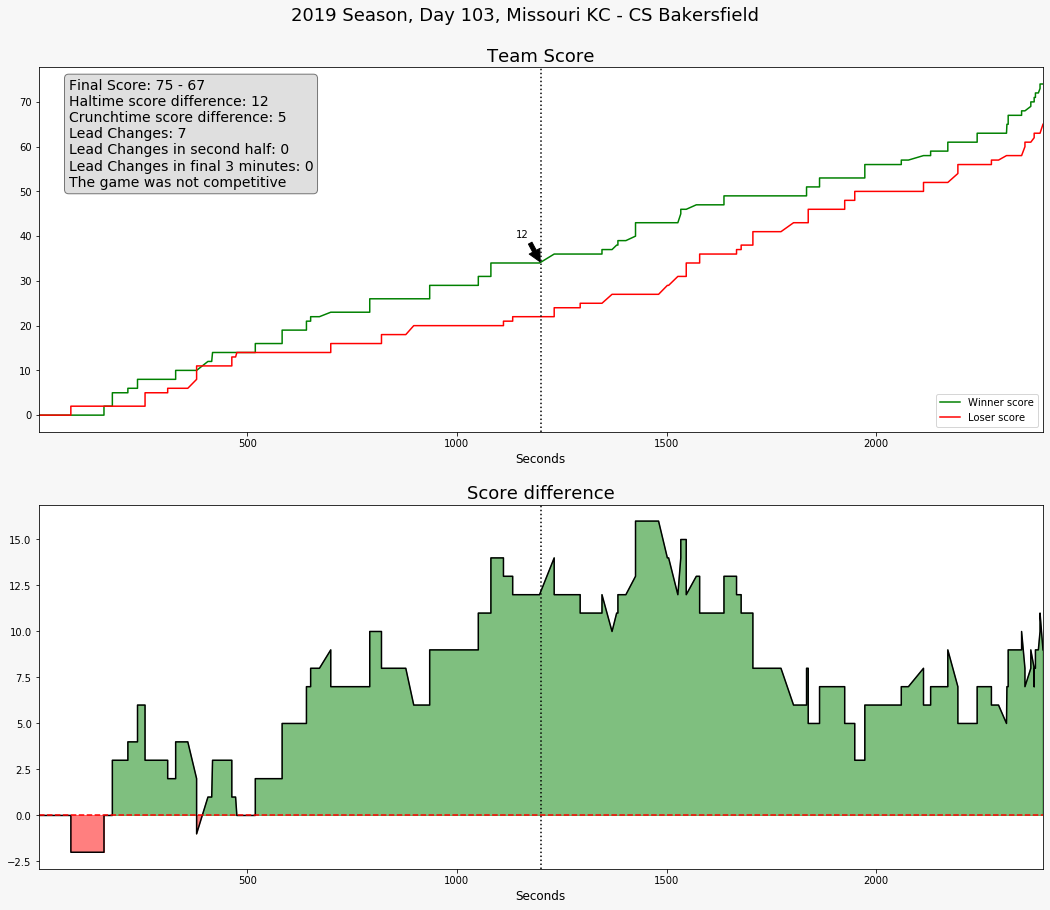

In [11]:
get_game(all_events_m, all_names)

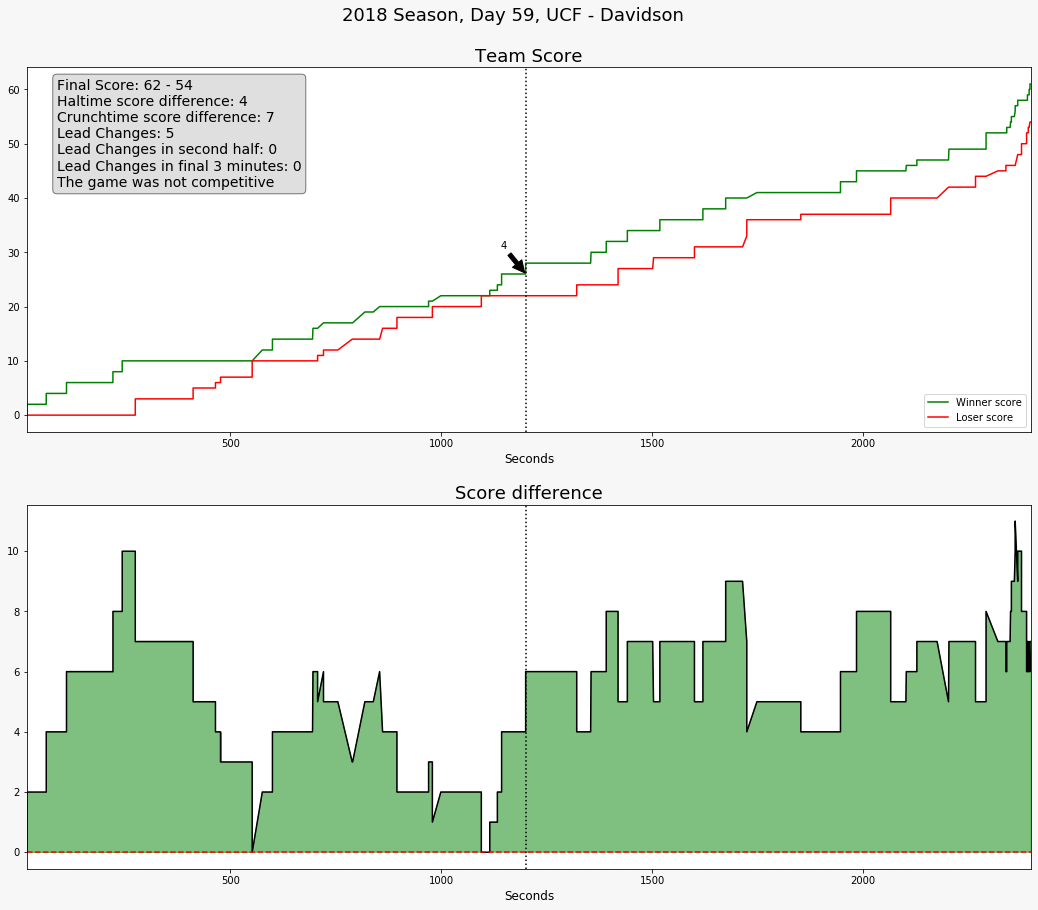

In [12]:
get_game(all_events_w, all_names)

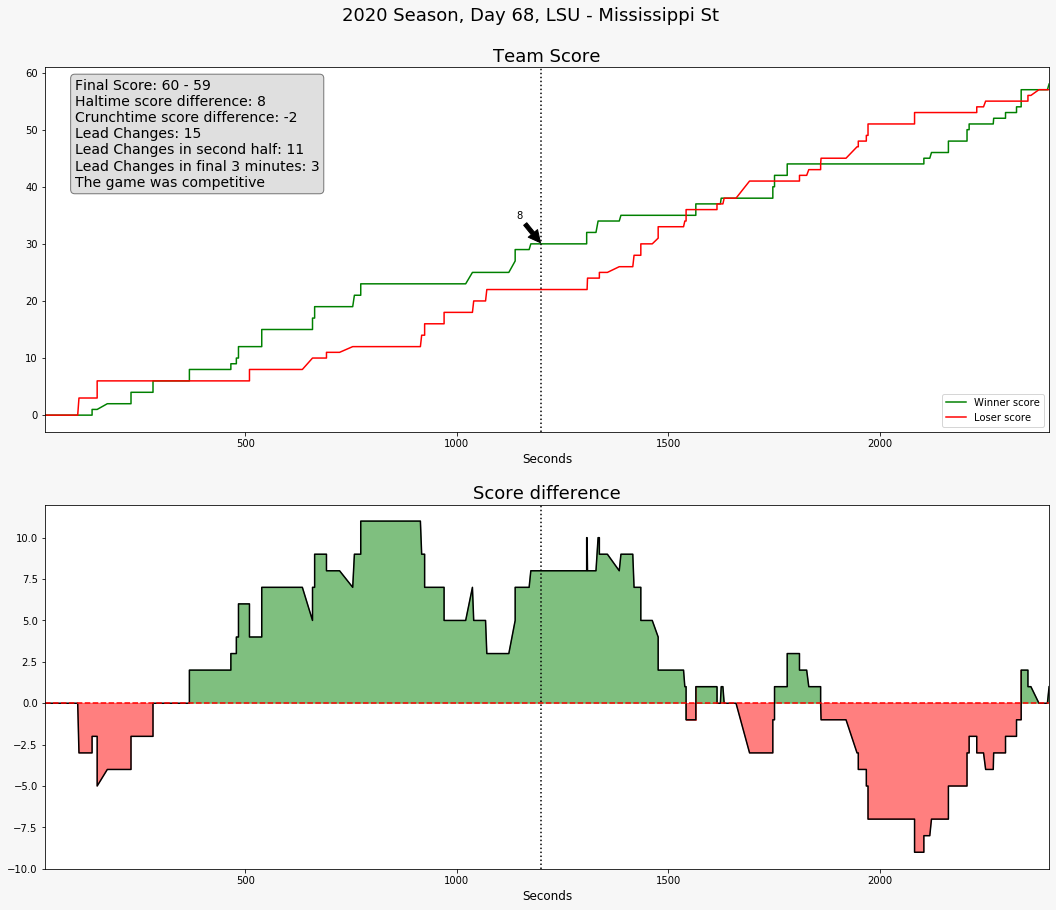

In [13]:
get_game(all_events_m, all_names, use_competitive=True, competitive=True)

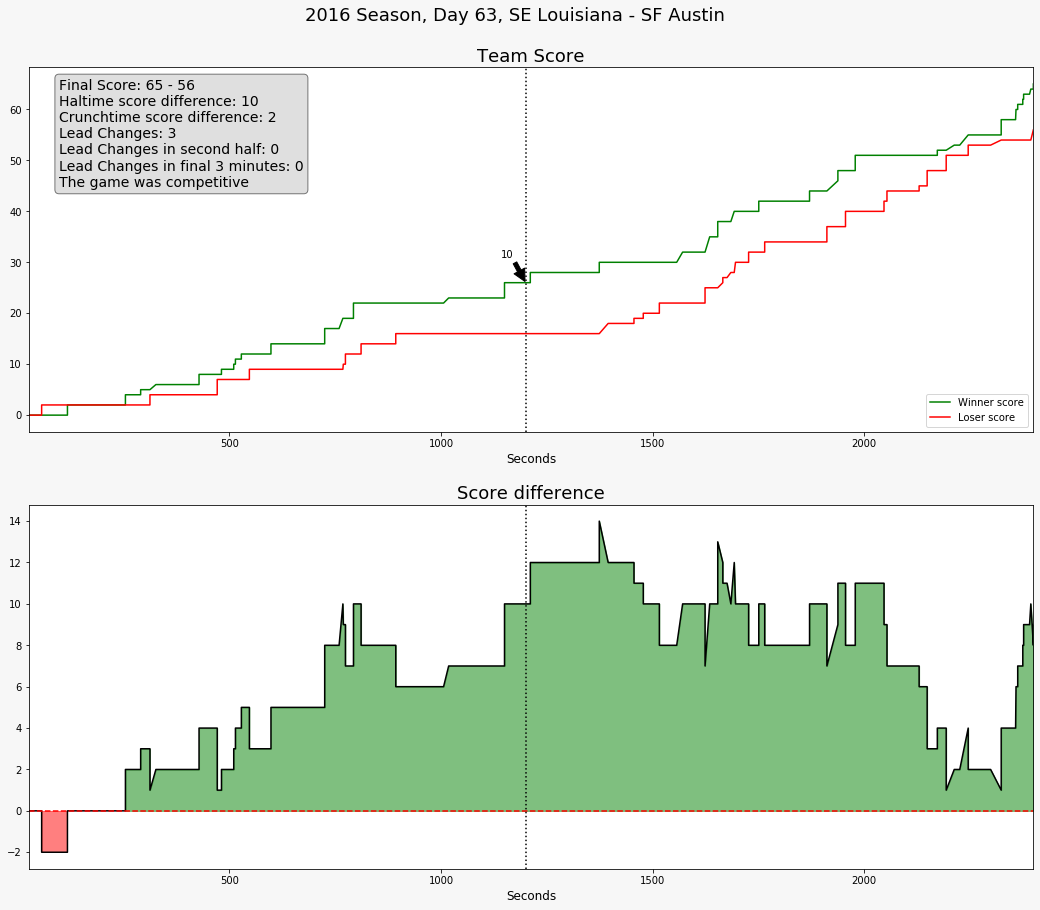

In [14]:
get_game(all_events_w, all_names, use_competitive=True, competitive=True)

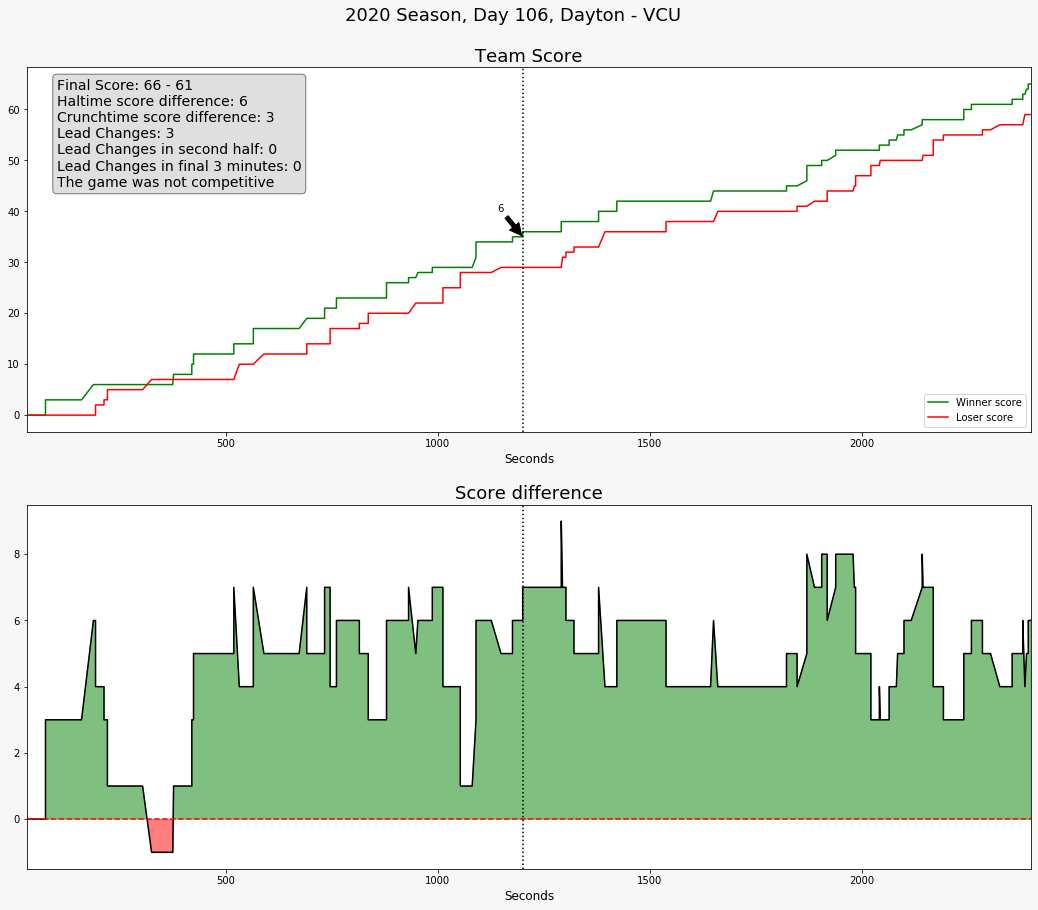

In [15]:
get_game(all_events_m, all_names, use_competitive=True, competitive=False)

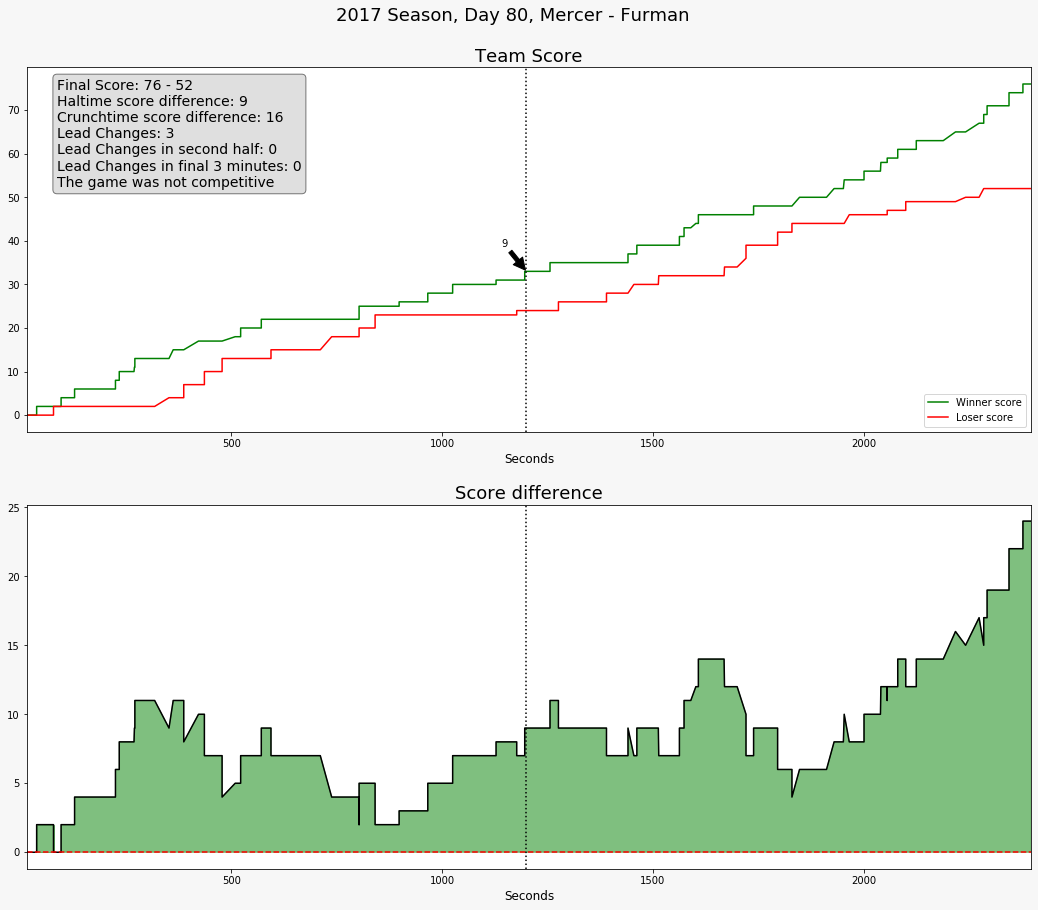

In [16]:
get_game(all_events_w, all_names, use_competitive=True, competitive=False)

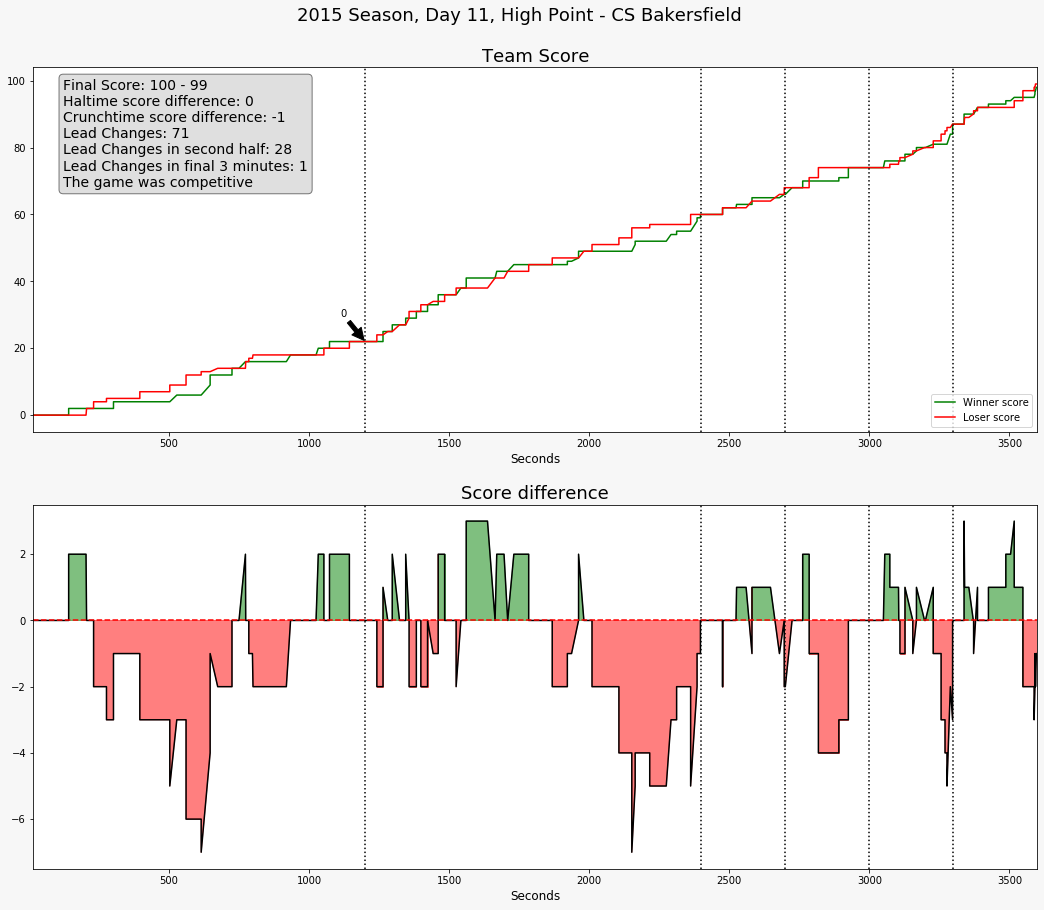

In [17]:
get_game(all_events_m, all_names, game_lc=True)

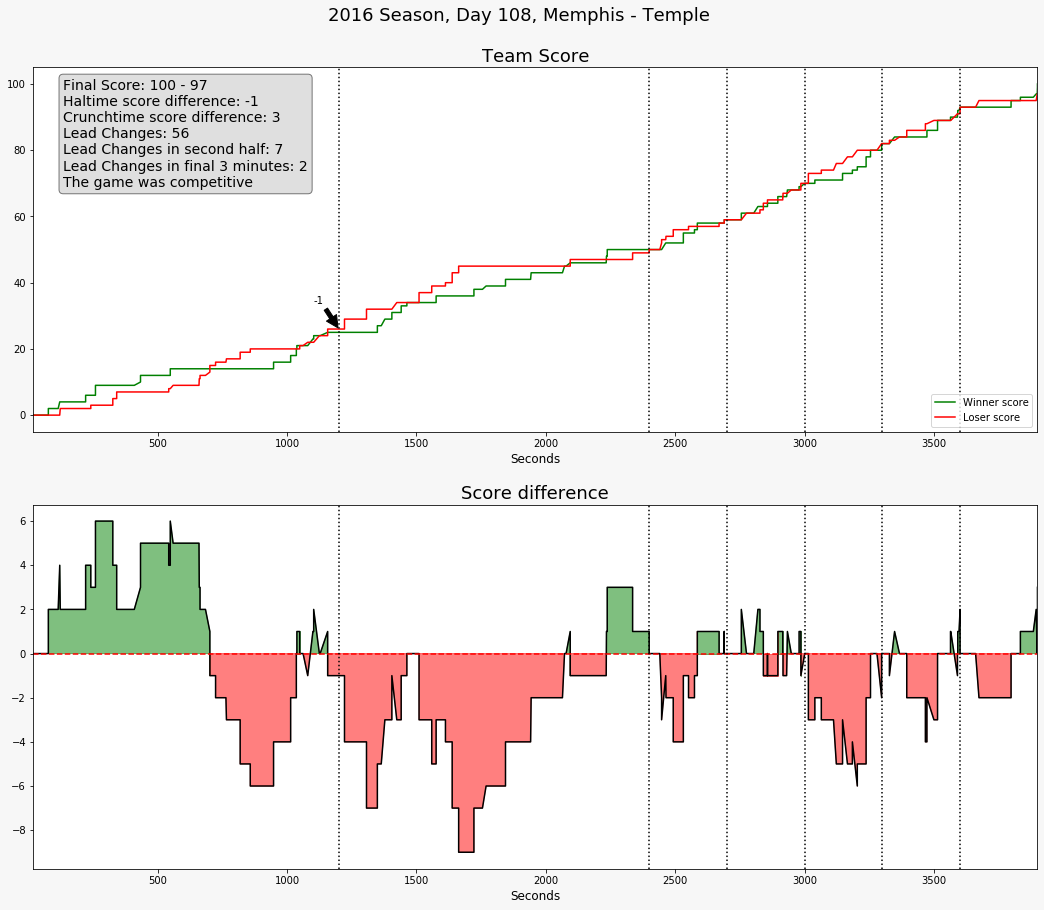

In [18]:
get_game(all_events_w, all_names, game_lc=True)

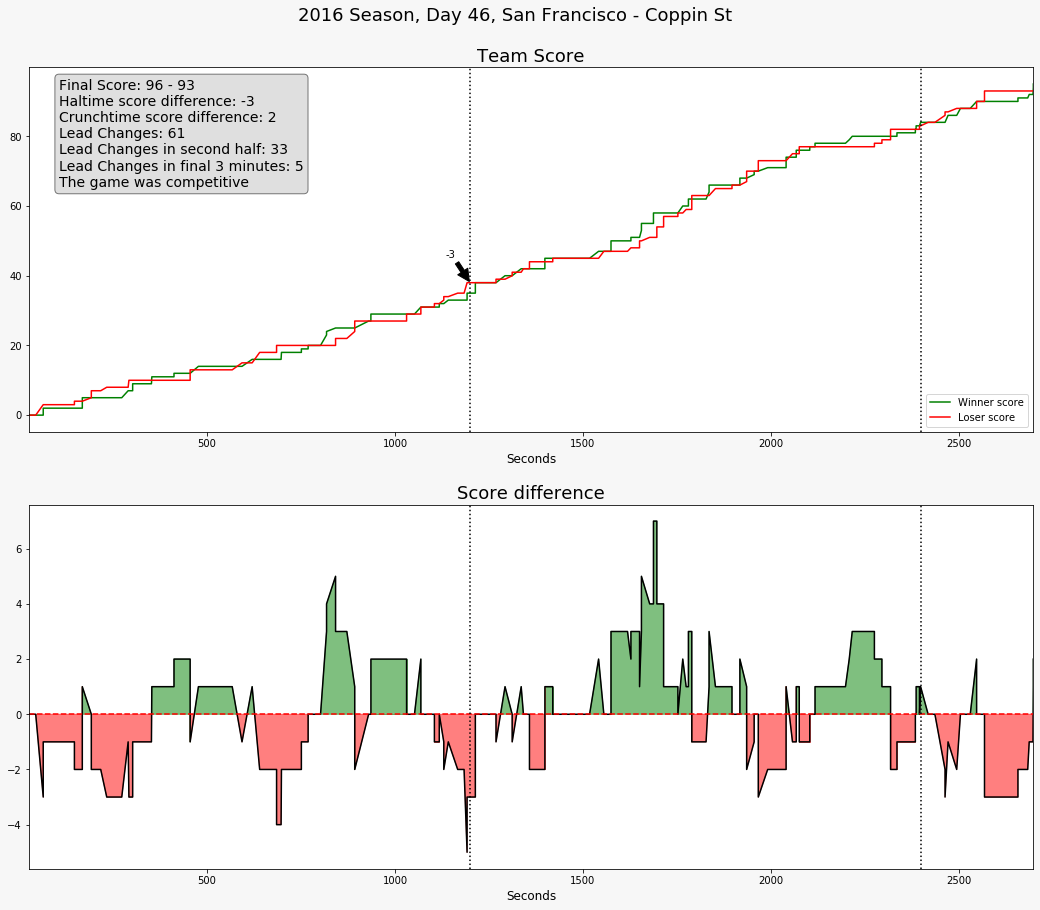

In [19]:
get_game(all_events_m, all_names, half_lc=True)

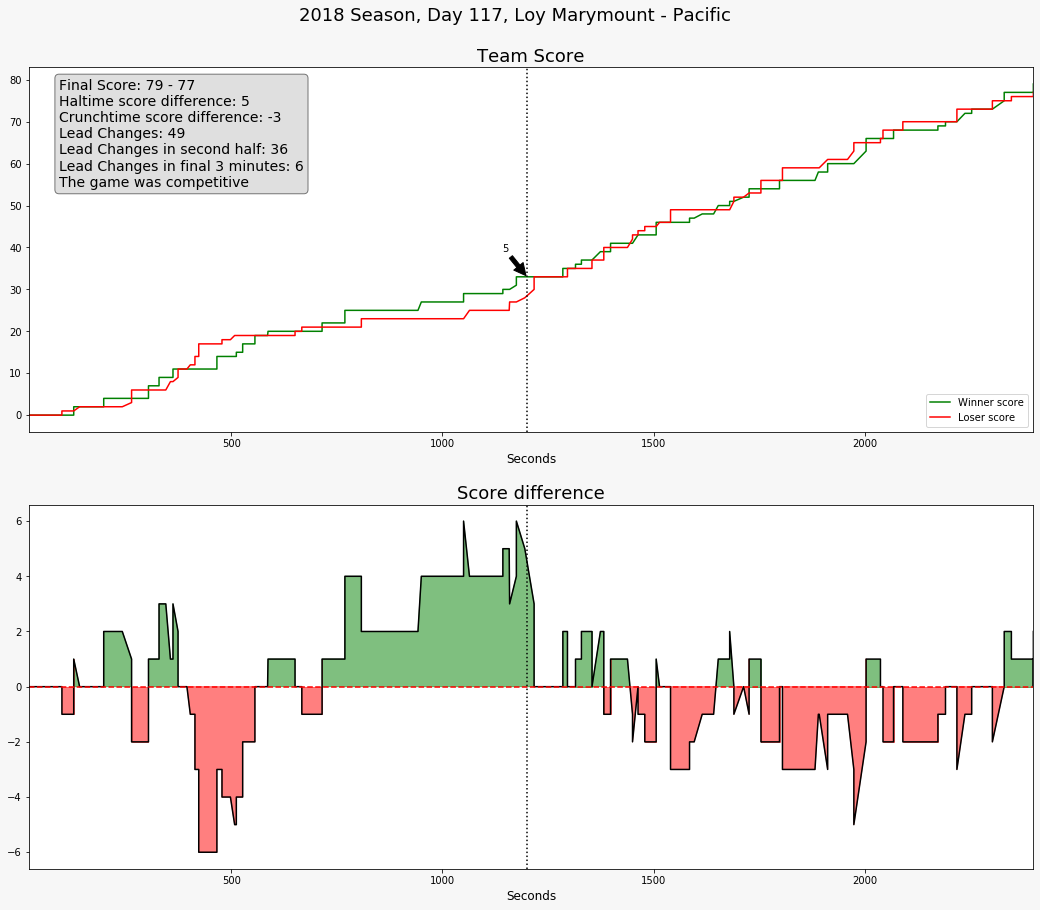

In [20]:
get_game(all_events_w, all_names, half_lc=True)

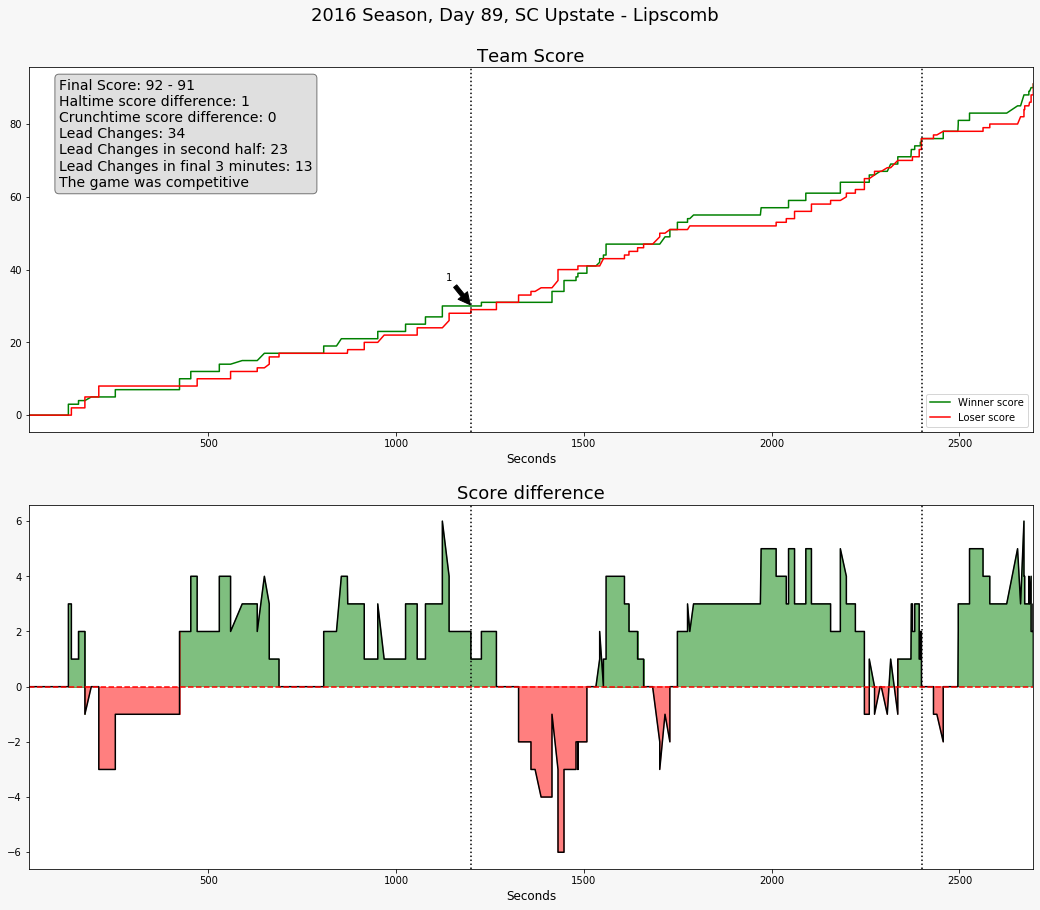

In [21]:
get_game(all_events_m, all_names, crunch_lc=True)

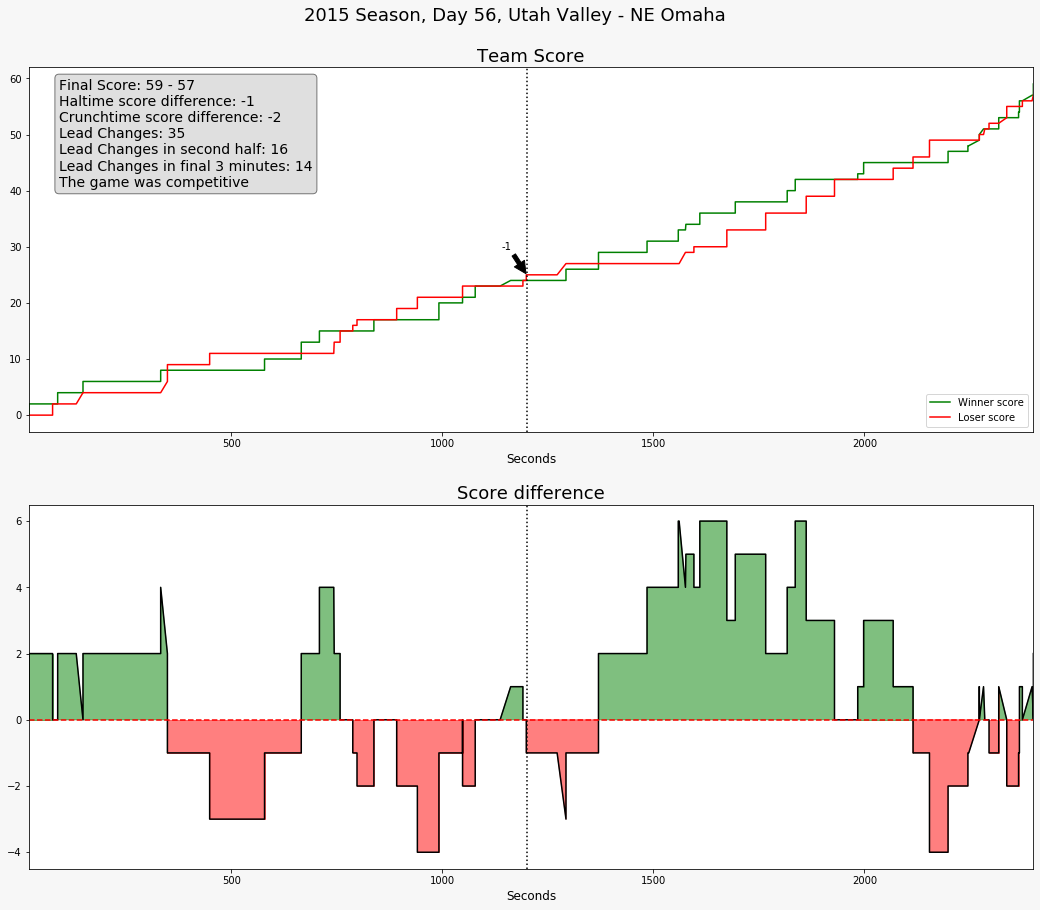

In [22]:
get_game(all_events_w, all_names, crunch_lc=True)

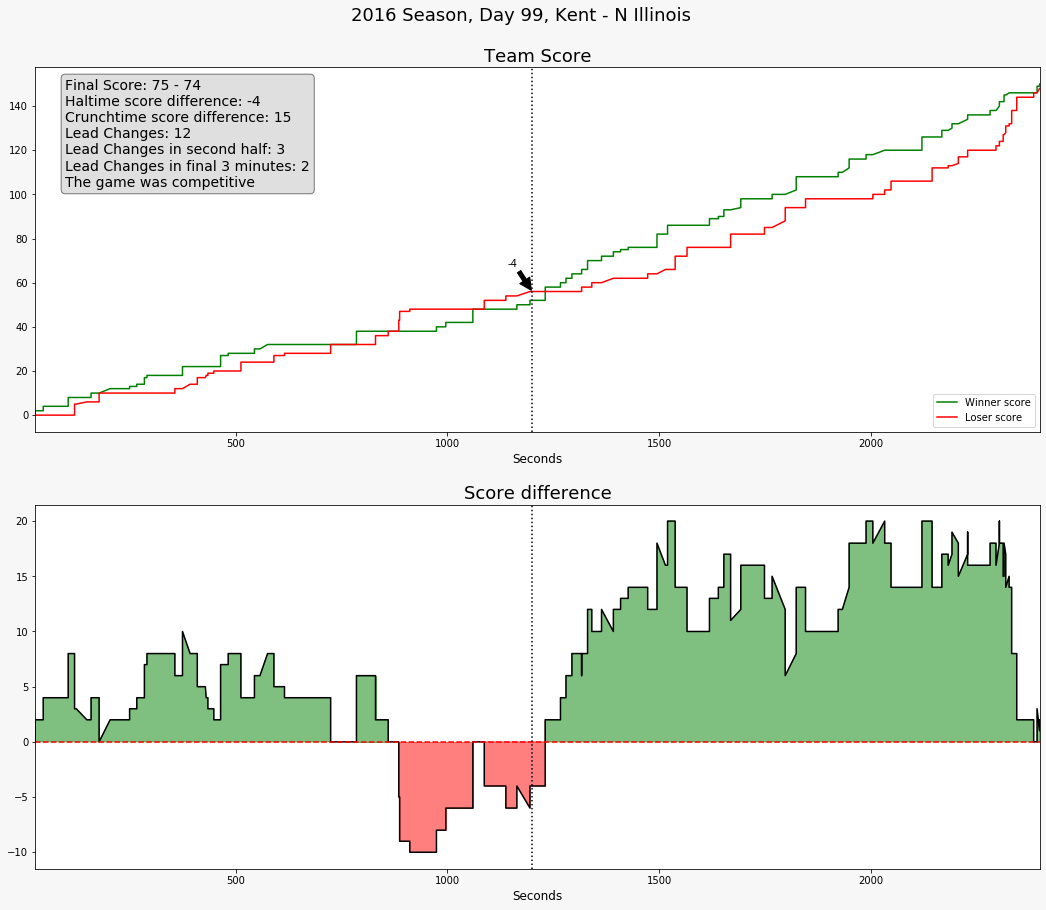

In [23]:
get_game(all_events_m, all_names, crunch_score=15, crunch_smaller=False, crunch_lc=True)

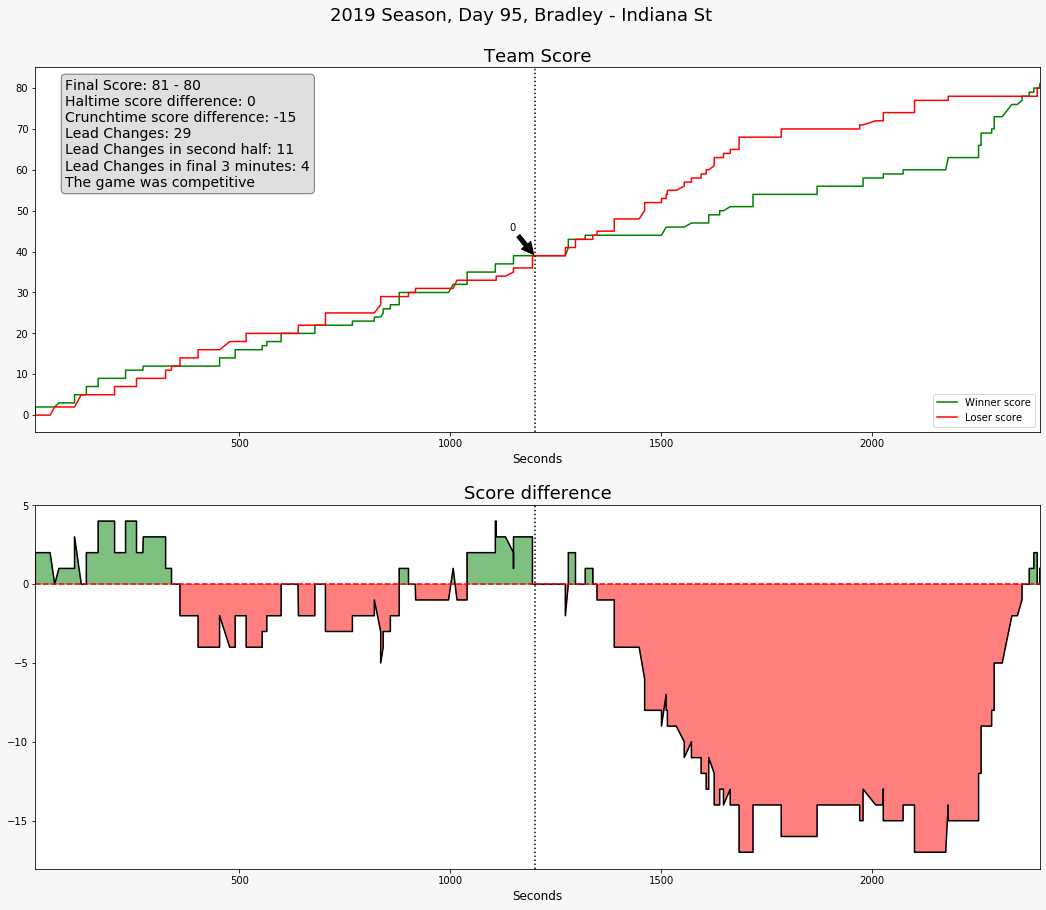

In [24]:
get_game(all_events_w, all_names, crunch_score=15, crunch_smaller=False, crunch_lc=True)